![](https://i.ytimg.com/vi/9rTTaey0McM/maxresdefault.jpg)

 ## Liberaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split


# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam

# metrics
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The Data

### `Train Data`

In [2]:
train_path = r"/kaggle/input/hymenoptera/hymenoptera/train"

Categories = ["ants", "bees"]

train_data = []
for category in Categories:
    label = Categories.index(category)  # 0 for ants & 1 for bees
    path = os.path.join(train_path, category)
    for img in os.listdir(path):
        the_img = os.path.join(path, img)
        try:
            image = cv2.imread(the_img)
            image = cv2.resize(image, (700, 700))
            train_data.append([image, label])
        except Exception as ex:
            pass

### `Test Data`

In [3]:
test_path = r"/kaggle/input/hymenoptera/hymenoptera/val"

Categories = ["ants", "bees"]

test_data = []
for category in Categories:
    label = Categories.index(category)  # 0 for ants & 1 for bees
    path = os.path.join(test_path, category)
    for img in os.listdir(path):
        the_img = os.path.join(path, img)
        try:
            image = cv2.imread(the_img)
            image = cv2.resize(image, (700, 700))
            test_data.append([image, label])
        except Exception as ex:
            pass

## Split The Data

In [4]:
# On The Train Data
X = []
y = []

for features, labels in train_data:
    X.append(features)
    y.append(labels)
    
X = np.array(X) # Features
y = np.array(y) # Targets

In [5]:
# Split To Train and Validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.13, random_state=42, shuffle=True)

In [6]:
# On The Test Data
X_test = []
y_test = []

for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)
    
X_test = np.array(X_test) # Features
y_test = np.array(y_test) # Targets

In [7]:
# shapes
print(f"X_train shape is {X_train.shape}")
print(f"y_train shape is {y_train.shape}")
print(f"X_valid shape is {X_valid.shape}")
print(f"y_valid shape is {y_valid.shape}")
print(f"X_test shape is {X_test.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (212, 700, 700, 3)
y_train shape is (212,)
X_valid shape is (32, 700, 700, 3)
y_valid shape is (32,)
X_test shape is (153, 700, 700, 3)
y_test shape is (153,)


## Exploratory Data Analysis (EDA)

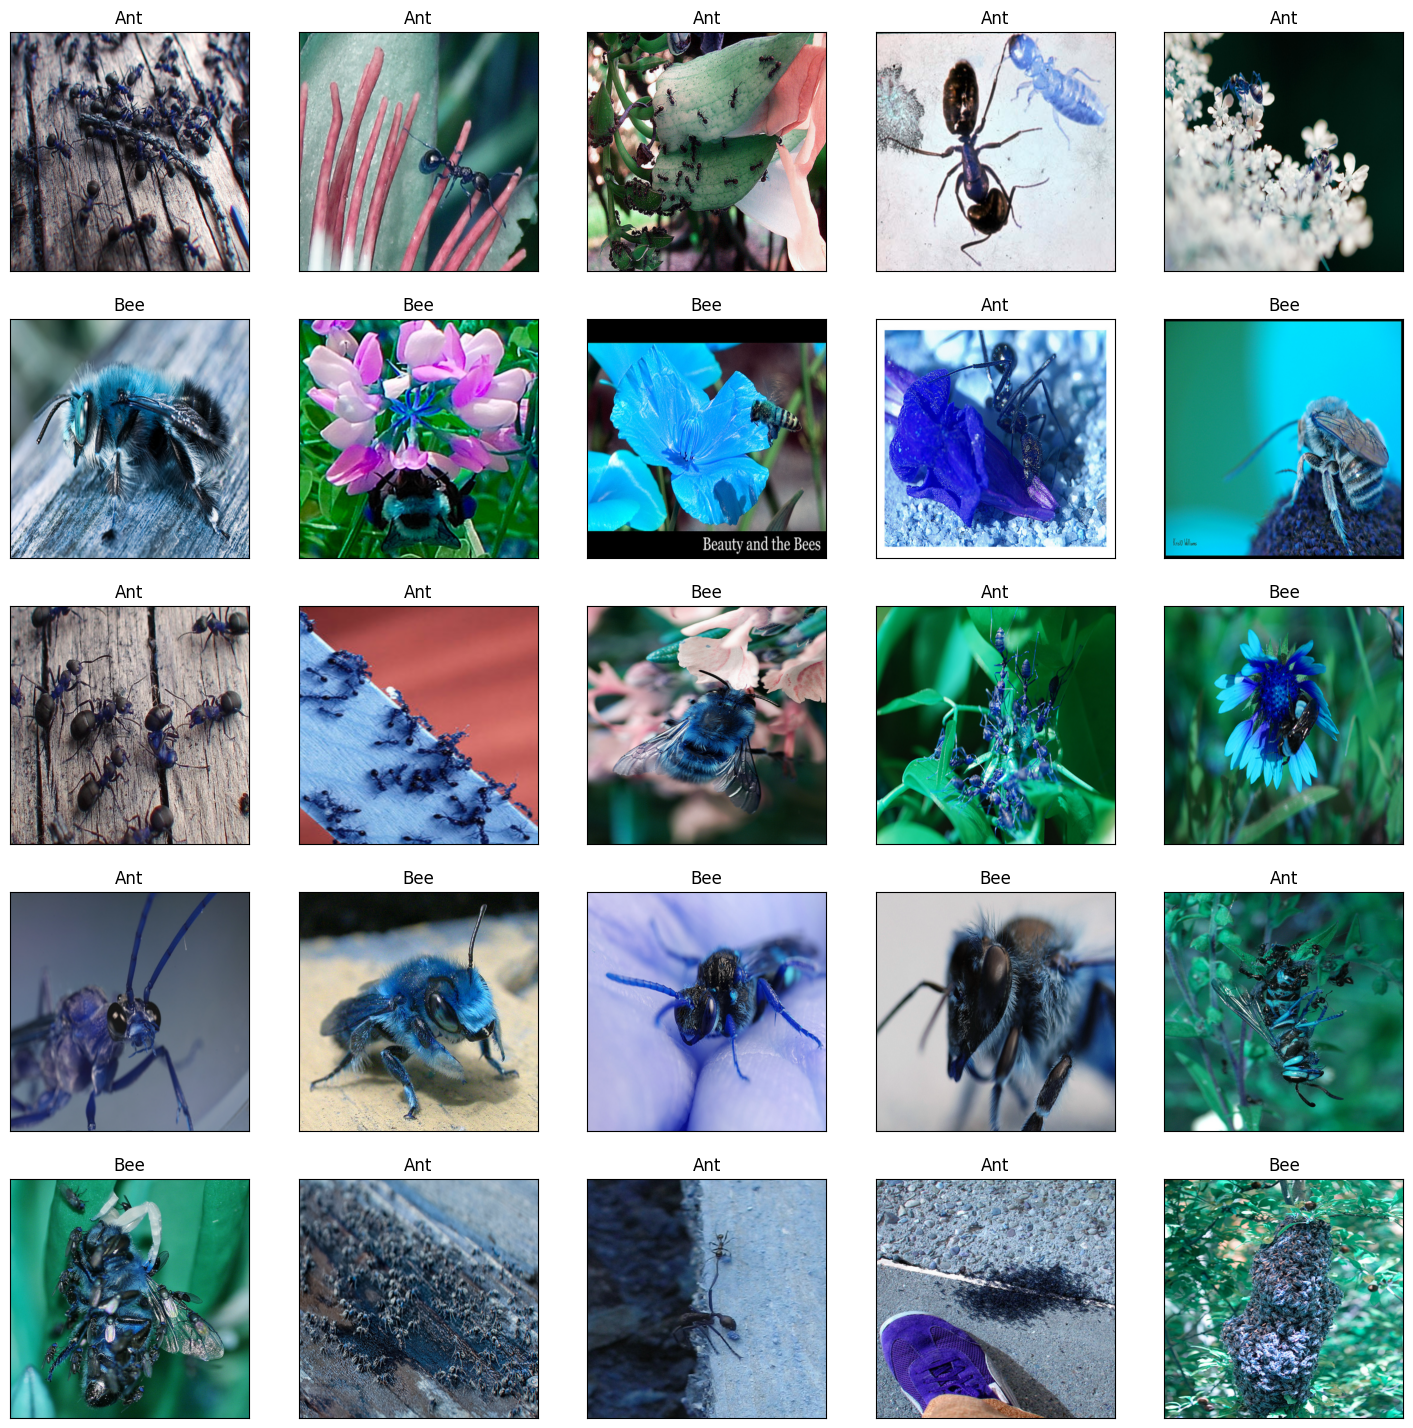

In [8]:
plt.figure(figsize=(18, 18))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    if y_train[i] == 0:
        plt.title("Ant")
    else:
        plt.title("Bee")
        
plt.show()

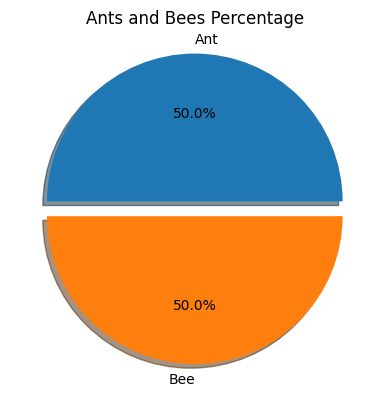

In [9]:
plt.pie([len(y_train[y_train==0]), len(y_train[y_train==1])], 
       labels=["Ant", "Bee"], autopct="%1.1f%%", shadow=True, explode=[0.1, 0])

plt.title("Ants and Bees Percentage")
plt.show()

#### `Class Distribution Bar Chart`

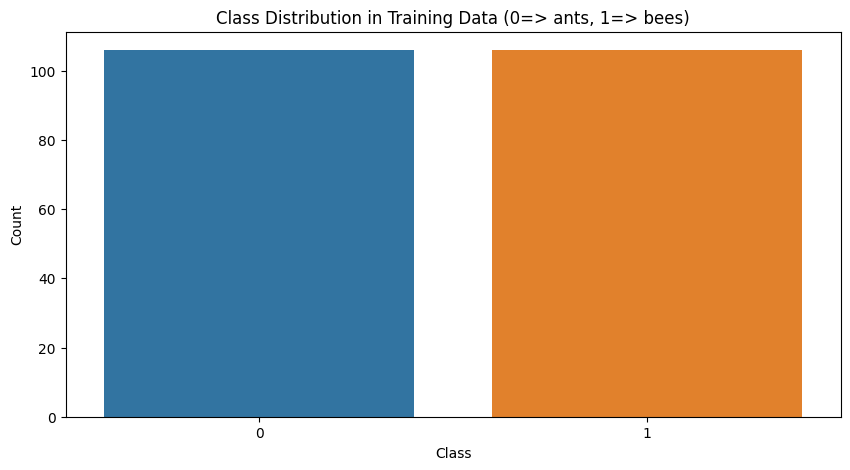

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Data (0=> ants, 1=> bees)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### `Image Statistics`

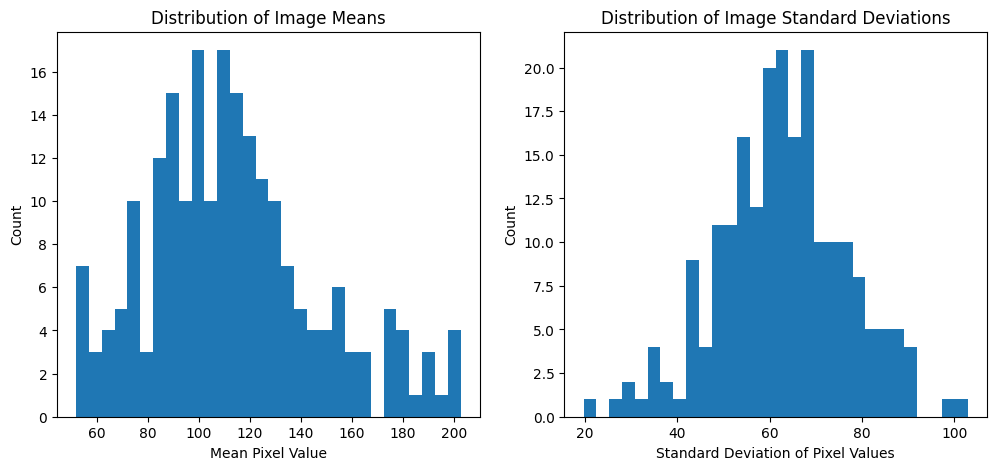

In [11]:
image_means = [np.mean(image) for image in X_train]
image_stds = [np.std(image) for image in X_train]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(image_means, bins=30)
plt.title('Distribution of Image Means')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(image_stds, bins=30)
plt.title('Distribution of Image Standard Deviations')
plt.xlabel('Standard Deviation of Pixel Values')
plt.ylabel('Count')

plt.show()

#### `distribution of pixel intensities`

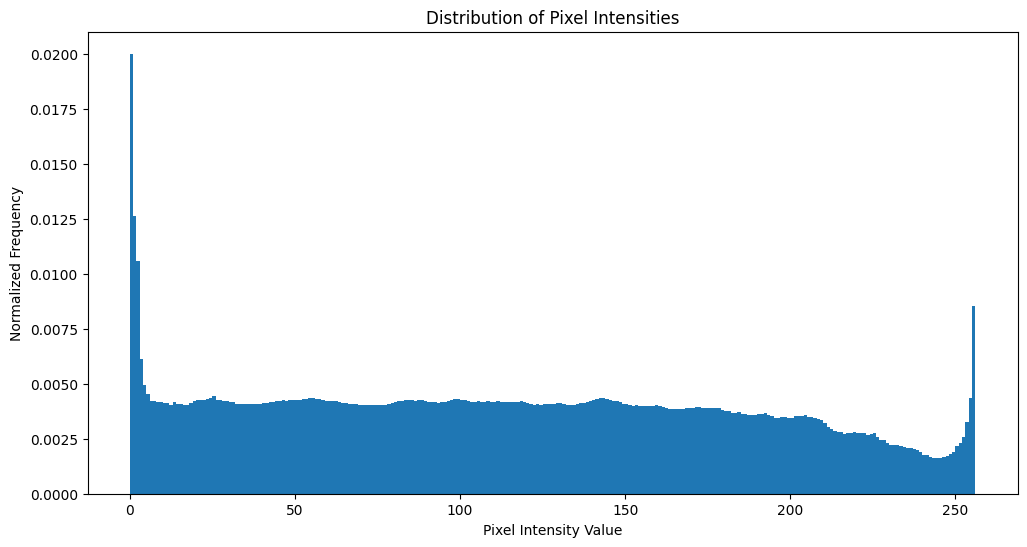

In [12]:
flattened_images = np.concatenate([image.flatten() for image in X_train])

# Plot the distribution of pixel intensities
plt.figure(figsize=(12, 6))
plt.hist(flattened_images, bins=256, range=[0, 256], density=True)
plt.title('Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Normalized Frequency')
plt.show()

#### `comparing average pixel intensity`

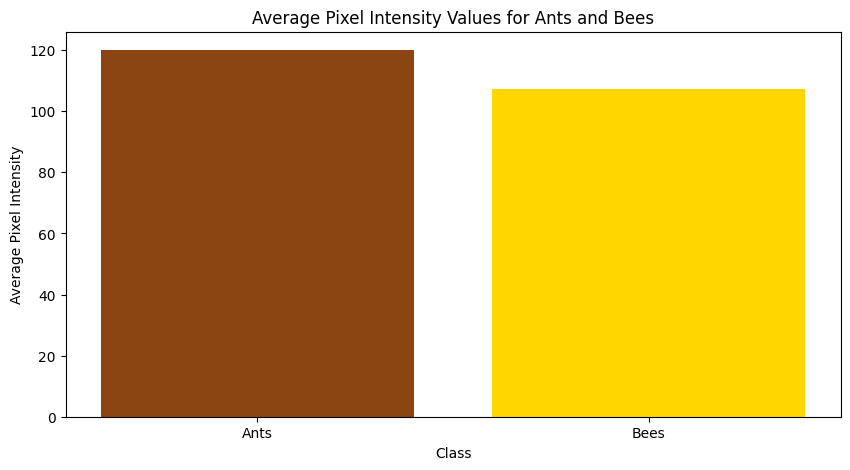

In [13]:
ants_average_intensity = np.mean([np.mean(image) for image, label in zip(X_train, y_train) if label == 0])
bees_average_intensity = np.mean([np.mean(image) for image, label in zip(X_train, y_train) if label == 1])

# Plot bar chart comparing average pixel intensity values
labels = ['Ants', 'Bees']
values = [ants_average_intensity, bees_average_intensity]
plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=['#8B4513', '#FFD700']) 
plt.title('Average Pixel Intensity Values for Ants and Bees')
plt.xlabel('Class')
plt.ylabel('Average Pixel Intensity')
plt.show()

## Normalization

In [14]:
# make the range of piexls between 0 & 1
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

## model

In [15]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 698, 698, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 349, 349, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 347, 347, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 173, 173, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 171, 171, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 85, 85, 128)       0

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping, checkpoint])


Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.2409 - accuracy: 0.5189
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 48s 3s/step - loss: 1.2409 - accuracy: 0.5189 - val_loss: 0.6428 - val_accuracy: 0.7188
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.6085
Epoch 2: val_accuracy did not improve from 0.71875
14/14 [==============================] - 7s 494ms/step - loss: 0.7669 - accuracy: 0.6085 - val_loss: 0.5222 - val_accuracy: 0.7188
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.6321
Epoch 3: val_accuracy improved from 0.71875 to 0.78125, saving model to best_model.h5
14/14 [==============================] - 35s 3s/step - loss: 0.6198 - accuracy: 0.6321 - val_loss: 0.5017 - val_accuracy: 0.7812
Epoch 4/10
14/14 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.7689
Epoch 4: val_accuracy improved from 0.78125 to 0.84375, saving model to best_model.h5
14/14 [==============================] - 34s 3s/step - loss: 0.4702 - accuracy: 0.7689 - val_loss: 0.4146 

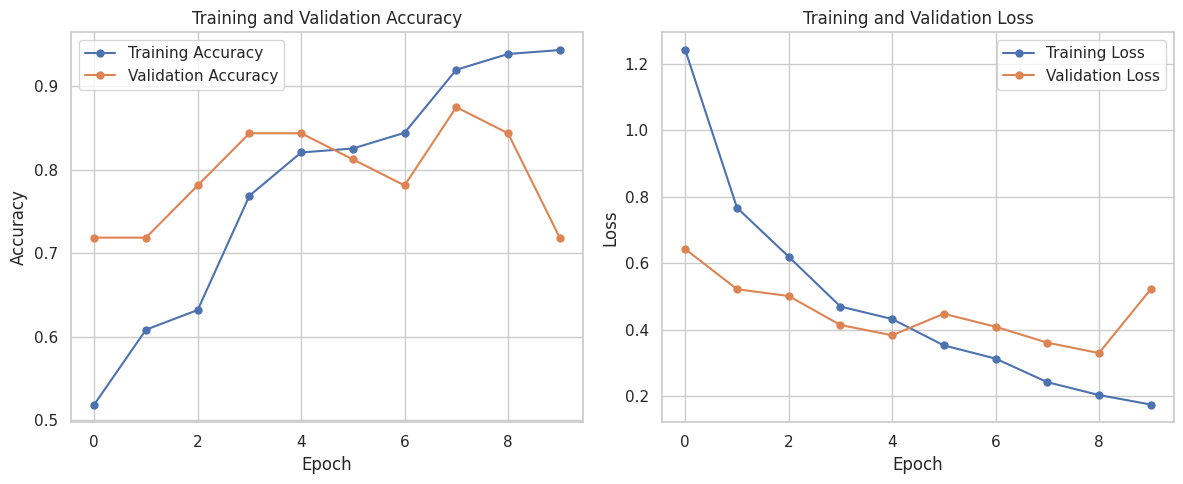

In [18]:
# back style
sns.set(style='whitegrid')

# Plotting training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o', markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', markersize=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### `evaluation and prediction`

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype('int32').reshape(-1)

5/5 [==============================] - 7s 807ms/step - loss: 0.8394 - accuracy: 0.6536
Test Accuracy: 65.36%
Test Loss: 0.8394
5/5 [==============================] - 1s 159ms/step


## Predictions

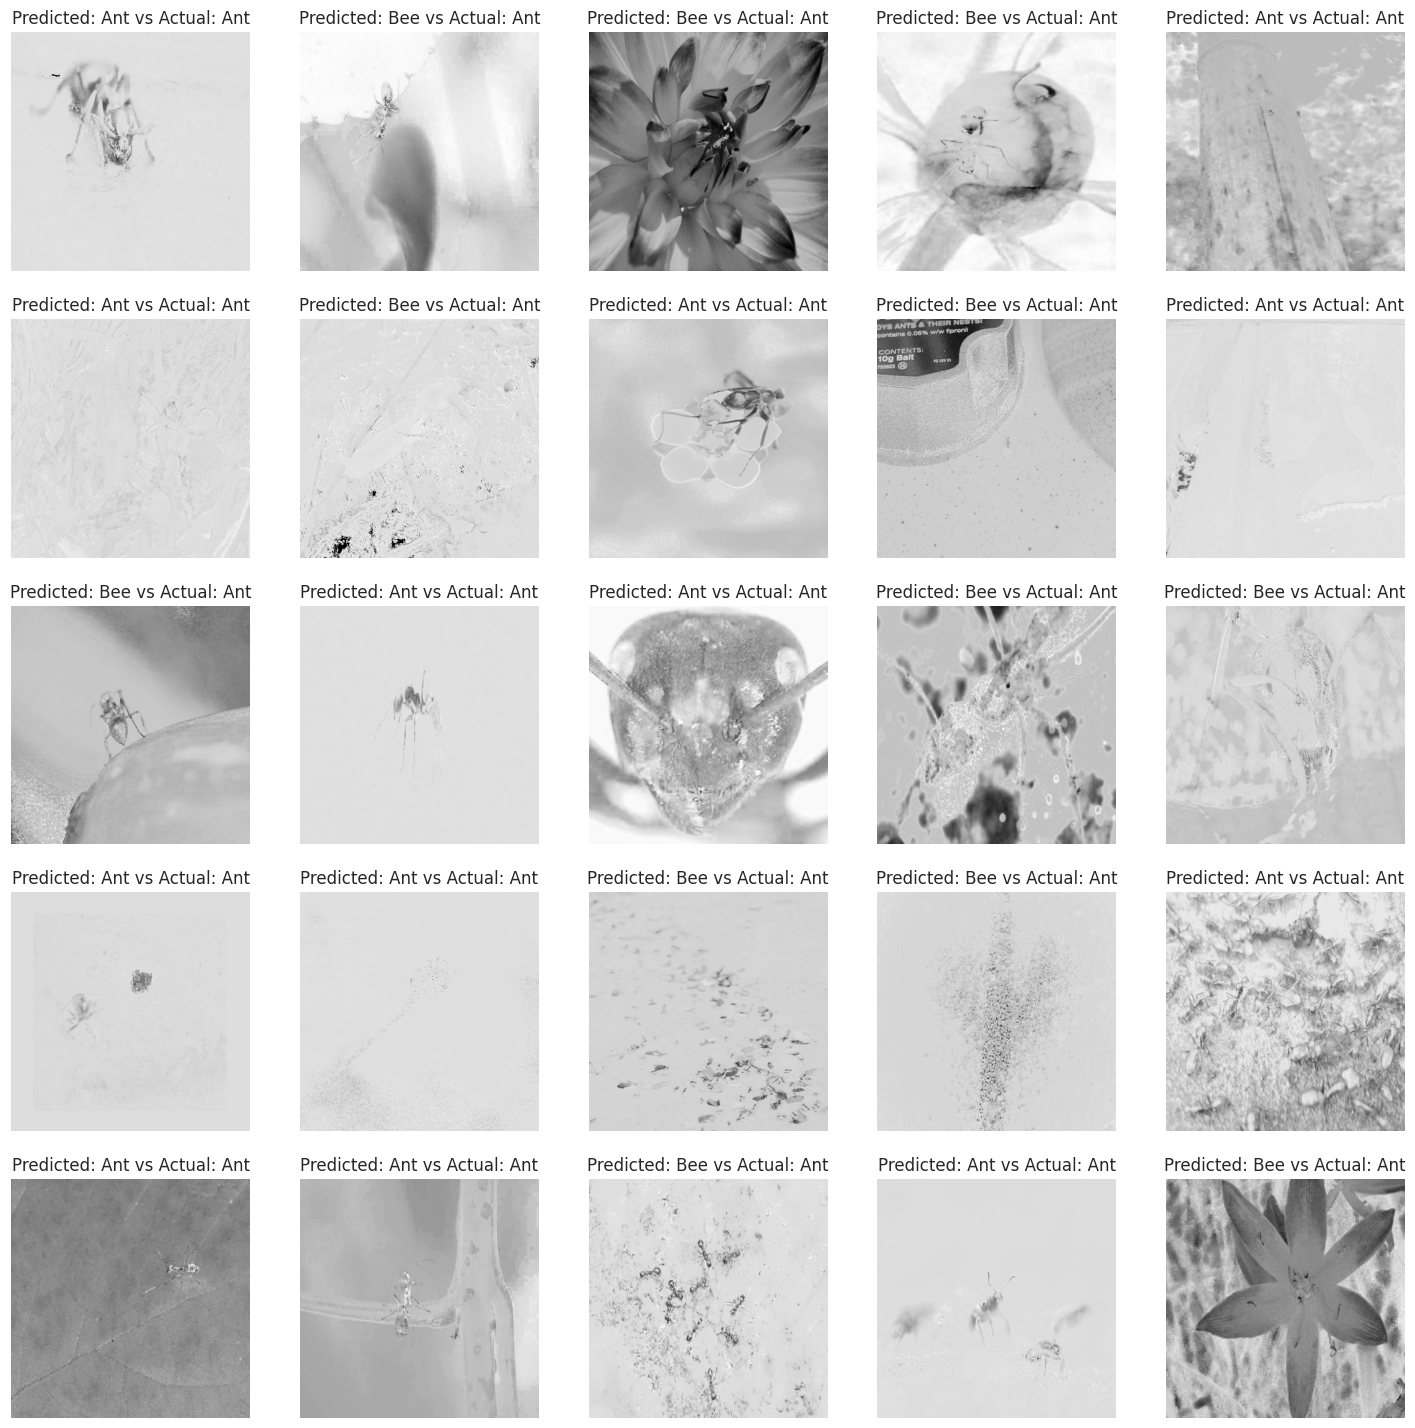

In [22]:
# Function to get label names
def get_label_name(label):
    class_names = ['Ant', 'Bee']
    return class_names[label]

# Plotting the grayscale images with predicted and actual labels
plt.figure(figsize=(18, 18))

for i in range(min(25, len(X_test))):
    plt.subplot(5, 5, i+1)
    
    
    grayscale_image = np.dot(X_test[i][...,:3], [0.299, 0.587, 0.114])
    
    plt.imshow(grayscale_image, cmap='gray')  
    plt.axis('off')  
    
    predicted_label = predicted_labels[i]
    actual_label = y_test[i]

    title = f"Predicted: {get_label_name(predicted_label)} vs Actual: {get_label_name(actual_label)}"
    plt.title(title)

plt.show()

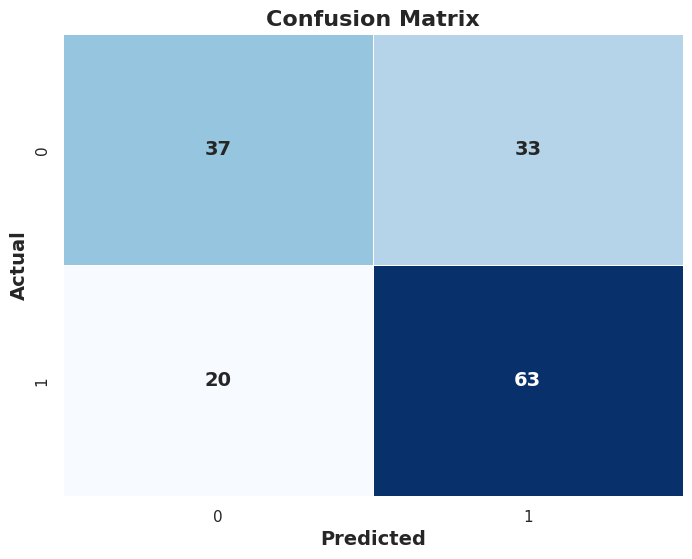

In [23]:
# Compute the confusion matrix
confusion = confusion_matrix(y_test, predicted_labels)
# Create a heatmap with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14, 'weight': 'bold'}, linewidths=.5)

# Customize labels and title
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [25]:
print("\033[1mThe Classification Report on Test Data\033[0m\n")
classification_rep = classification_report(y_test, predicted_labels)
print(classification_rep)

The Classification Report on Test Data

              precision    recall  f1-score   support

           0       0.65      0.53      0.58        70
           1       0.66      0.76      0.70        83

    accuracy                           0.65       153
   macro avg       0.65      0.64      0.64       153
weighted avg       0.65      0.65      0.65       153



# By: Mohammed Hamza